In [ ]:
import os
import cv2
import sys
import zipfile
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Définir les chemins
zip_path = "D:\\deep learning\\TP 7\\amhcd-data-64.zip"
extract_path = "D:\\deep learning\\TP 7\\amhcd-data-64"
data_dir = extract_path

# Extraire le dataset si nécessaire
if not os.path.exists(extract_path):
    if os.path.exists(zip_path):
        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(os.path.dirname(extract_path))
                print(f"Extracted dataset to {extract_path}")
        except zipfile.BadZipFile:
            print(f"Error: Corrupted ZIP file at {zip_path}")
    else:
        print(f"ZIP file not found at {zip_path}")
else:
    print(f"Dataset already exists at {extract_path}")

# Fonction de prétraitement des images
def load_and_preprocess_image(image_path, data_dir, target_size=(32, 32)):
    """Load and preprocess image: grayscale, resize, normalize"""
    full_path = os.path.join(data_dir, image_path)
    assert os.path.exists(full_path), f"Image not found: {full_path}"
    img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
    assert img is not None, f"Failed to load image: {full_path}"
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    return img

# Charger les étiquettes depuis labels-map.csv
labels_csv_path = os.path.join(data_dir, "labels-map.csv")
if not os.path.exists(labels_csv_path):
    print(f"labels-map.csv not found. Building DataFrame from directory.")
    image_paths, labels = [], []
    tifinagh_dir = os.path.join(data_dir, "tifinagh-images")
    if not os.path.exists(tifinagh_dir):
        raise FileNotFoundError(f"Tifinagh images directory not found: {tifinagh_dir}")
    for label_dir in os.listdir(tifinagh_dir):
        label_path = os.path.join(tifinagh_dir, label_dir)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                image_paths.append(os.path.join("tifinagh-images", label_dir, img_name))
                labels.append(label_dir)
    labels_df = pd.DataFrame({'image_path': image_paths, 'label': labels})
else:
    print(f"Loading labels from {labels_csv_path}")
    labels_df = pd.read_csv(labels_csv_path, names=['image_path', 'label'])

assert not labels_df.empty, "No data loaded. Check dataset files."
labels_df['image_path'] = labels_df['image_path'].apply(lambda x: x.replace('./images-data-64/', '') if isinstance(x, str) else x)

# Encodage des étiquettes
label_encoder = LabelEncoder()
labels_df['label_encoded'] = label_encoder.fit_transform(labels_df['label'])
num_classes = len(label_encoder.classes_)
print(f"Loaded {len(labels_df)} samples with {labels_df['label'].nunique()} unique classes.")

# Charger toutes les images
X = np.array([load_and_preprocess_image(path, data_dir) for path in labels_df['image_path']])
X = X.reshape(-1, 32, 32, 1)  # Ajouter une dimension pour les canaux
y = labels_df['label_encoded'].values

# Diviser en ensembles d'entraînement, validation et test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Convertir en one-hot encoding
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_train_one_hot = one_hot_encoder.fit_transform(y_train.reshape(-1, 1))
y_val_one_hot = one_hot_encoder.transform(y_val.reshape(-1, 1))
y_test_one_hot = one_hot_encoder.transform(y_test.reshape(-1, 1))
print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

# Implémentation de LeNet-5 avec Adam
class LeNet5:
    def __init__(self, input_shape=(32, 32, 1), num_classes=33, learning_rate=0.001):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.weights = {}
        self.biases = {}
        
        # Paramètres Adam
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8
        self.t = 0
        
        self.initialize_weights()
        self.initialize_adam()
    
    def initialize_weights(self):
        # Initialisation He pour meilleure convergence avec ReLU
        # C1: 6 filtres 5x5
        self.weights['C1'] = np.random.randn(5, 5, 1, 6) * np.sqrt(2.0 / (5*5*1))
        self.biases['C1'] = np.zeros((6,))
        # C3: 16 filtres 5x5
        self.weights['C3'] = np.random.randn(5, 5, 6, 16) * np.sqrt(2.0 / (5*5*6))
        self.biases['C3'] = np.zeros((16,))
        # C5: 120 neurones
        self.weights['C5'] = np.random.randn(5 * 5 * 16, 120) * np.sqrt(2.0 / (5*5*16))
        self.biases['C5'] = np.zeros((120,))
        # F6: 84 neurones
        self.weights['F6'] = np.random.randn(120, 84) * np.sqrt(2.0 / 120)
        self.biases['F6'] = np.zeros((84,))
        # Output: 33 classes
        self.weights['output'] = np.random.randn(84, self.num_classes) * np.sqrt(2.0 / 84)
        self.biases['output'] = np.zeros((self.num_classes,))
    
    def initialize_adam(self):
        # Initialisation des moments pour Adam
        self.m_w = {k: np.zeros_like(v) for k, v in self.weights.items()}
        self.v_w = {k: np.zeros_like(v) for k, v in self.weights.items()}
        self.m_b = {k: np.zeros_like(v) for k, v in self.biases.items()}
        self.v_b = {k: np.zeros_like(v) for k, v in self.biases.items()}

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def conv2d(self, x, W, b, stride=1, padding=0):
        """Convolution vectorisée"""
        batch_size, in_h, in_w, in_c = x.shape
        f_h, f_w, _, out_c = W.shape
        
        # Calcul des dimensions de sortie
        out_h = (in_h - f_h + 2 * padding) // stride + 1
        out_w = (in_w - f_w + 2 * padding) // stride + 1
        
        # Padding
        if padding > 0:
            pad_width = ((0, 0), (padding, padding), (padding, padding), (0, 0))
            x_padded = np.pad(x, pad_width, mode='constant')
        else:
            x_padded = x
        
        # Convolution vectorisée
        output = np.zeros((batch_size, out_h, out_w, out_c))
        
        for i in range(out_h):
            for j in range(out_w):
                h_start = i * stride
                h_end = h_start + f_h
                w_start = j * stride
                w_end = w_start + f_w
                
                patch = x_padded[:, h_start:h_end, w_start:w_end, :]
                
                for k in range(out_c):
                    output[:, i, j, k] = np.sum(patch * W[..., k], axis=(1, 2, 3))
        
        output += b
        return output

    def avg_pooling(self, x, size=2, stride=2):
        """Pooling moyen avec format channels-last"""
        batch, in_h, in_w, channels = x.shape
        out_h = (in_h - size) // stride + 1
        out_w = (in_w - size) // stride + 1
        
        output = np.zeros((batch, out_h, out_w, channels))
        
        for i in range(out_h):
            for j in range(out_w):
                h_start = i * stride
                h_end = h_start + size
                w_start = j * stride
                w_end = w_start + size
                
                window = x[:, h_start:h_end, w_start:w_end, :]
                output[:, i, j, :] = np.mean(window, axis=(1, 2))
                
        return output

    def forward(self, X):
        self.activations = {}
        # C1: Convolution 5x5 -> 6 filtres
        self.activations['C1'] = self.relu(self.conv2d(X, self.weights['C1'], self.biases['C1']))
        # S2: Pooling moyen 2x2
        self.activations['S2'] = self.avg_pooling(self.activations['C1'])
        # C3: Convolution 5x5 -> 16 filtres
        self.activations['C3'] = self.relu(self.conv2d(self.activations['S2'], self.weights['C3'], self.biases['C3']))
        # S4: Pooling moyen 2x2
        self.activations['S4'] = self.avg_pooling(self.activations['C3'])
        # C5: Couche fully connected
        flattened = self.activations['S4'].reshape(X.shape[0], -1)
        self.activations['C5'] = self.relu(np.dot(flattened, self.weights['C5']) + self.biases['C5'])
        # F6: Couche fully connected
        self.activations['F6'] = self.relu(np.dot(self.activations['C5'], self.weights['F6']) + self.biases['F6'])
        # Output: Couche de sortie
        output_layer = np.dot(self.activations['F6'], self.weights['output']) + self.biases['output']
        self.activations['output'] = self.softmax(output_layer)
        return self.activations['output']

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        epsilon = 1e-15
        return -np.sum(y_true * np.log(y_pred + epsilon)) / m

    def compute_accuracy(self, y_true, y_pred):
        predictions = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y_true, axis=1)
        return np.mean(predictions == true_labels)

    def backward(self, X, y, y_pred, optimizer='Adam'):
        m = X.shape[0]
        self.gradients = {}
        
        # Output layer
        dZ_output = (y_pred - y) / m
        self.gradients['output_w'] = np.dot(self.activations['F6'].T, dZ_output)
        self.gradients['output_b'] = np.sum(dZ_output, axis=0)
        
        # F6 layer
        dA_F6 = np.dot(dZ_output, self.weights['output'].T) * self.relu_derivative(self.activations['F6'])
        self.gradients['F6_w'] = np.dot(self.activations['C5'].T, dA_F6)
        self.gradients['F6_b'] = np.sum(dA_F6, axis=0)
        
        # C5 layer
        dA_C5 = np.dot(dA_F6, self.weights['F6'].T) * self.relu_derivative(self.activations['C5'])
        self.gradients['C5_w'] = np.dot(self.activations['S4'].reshape(m, -1).T, dA_C5)
        self.gradients['C5_b'] = np.sum(dA_C5, axis=0)
        
        # Mise à jour Adam
        self.t += 1
        for layer in ['C1', 'C3', 'C5', 'F6', 'output']:
            # Mise à jour des poids
            self.m_w[layer] = self.beta1 * self.m_w[layer] + (1 - self.beta1) * self.gradients.get(f'{layer}_w', 0)
            self.v_w[layer] = self.beta2 * self.v_w[layer] + (1 - self.beta2) * np.square(self.gradients.get(f'{layer}_w', 0))
            
            m_hat_w = self.m_w[layer] / (1 - self.beta1**self.t)
            v_hat_w = self.v_w[layer] / (1 - self.beta2**self.t)
            
            self.weights[layer] -= self.learning_rate * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)
            
            # Mise à jour des biais
            self.m_b[layer] = self.beta1 * self.m_b[layer] + (1 - self.beta1) * self.gradients.get(f'{layer}_b', 0)
            self.v_b[layer] = self.beta2 * self.v_b[layer] + (1 - self.beta2) * np.square(self.gradients.get(f'{layer}_b', 0))
            
            m_hat_b = self.m_b[layer] / (1 - self.beta1**self.t)
            v_hat_b = self.v_b[layer] / (1 - self.beta2**self.t)
            
            self.biases[layer] -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)

    def train(self, X_train, y_train, X_val, y_val, epochs=20, batch_size=32, optimizer='Adam'):
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        
        for epoch in range(epochs):
            # Mélange des données
            indices = np.random.permutation(X_train.shape[0])
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            epoch_loss = 0
            
            # Entraînement par batch
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                y_batch_one_hot = one_hot_encoder.transform(y_batch.reshape(-1, 1))
                
                # Forward pass
                outputs = self.forward(X_batch)
                batch_loss = self.compute_loss(y_batch_one_hot, outputs)
                epoch_loss += batch_loss
                
                # Backward pass
                self.backward(X_batch, y_batch_one_hot, outputs, optimizer)
            
            # Calcul des métriques
            train_loss = epoch_loss / (X_train.shape[0] // batch_size)
            train_pred = self.forward(X_train)
            train_accuracy = self.compute_accuracy(y_train_one_hot, train_pred)
            
            val_pred = self.forward(X_val)
            val_loss = self.compute_loss(y_val_one_hot, val_pred)
            val_accuracy = self.compute_accuracy(y_val_one_hot, val_pred)
            
            # Stockage des résultats
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
        
        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)

# Visualisation des cartes caractéristiques
def visualize_feature_maps(activations, layer_name, num_filters=6):
    plt.figure(figsize=(12, 2))
    for i in range(min(num_filters, activations.shape[-1])):
        plt.subplot(1, num_filters, i+1)
        plt.imshow(activations[0, :, :, i], cmap='gray')
        plt.axis('off')
        plt.title(f'Filter {i+1}')
    plt.suptitle(f'Feature Maps - {layer_name}')
    plt.savefig(f'{layer_name}_feature_maps.png')
    plt.close()

# Entraîner le modèle avec Adam
print("----------Training model with Adam optimizer------------")
model = LeNet5(num_classes=num_classes, learning_rate=0.001)
train_losses, val_losses, train_accuracies, val_accuracies = model.train(
    X_train, y_train, X_val, y_val, 
    epochs=20, 
    batch_size=32, 
    optimizer='Adam'
)

# Visualisations
# Courbes de perte et précision
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.close()

# Matrice de confusion
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Test set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.close()

# Visualisation des cartes caractéristiques (exemple pour C1)
visualize_feature_maps(model.activations['C1'], 'C1')

# Rapport de classification
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Dataset already exists at D:\deep learning\TP 7\amhcd-data-64
Loading labels from D:\deep learning\TP 7\amhcd-data-64\labels-map.csv
Loaded 28182 samples with 33 unique classes.
Train: 16908, Val: 5637, Test: 5637
----------Training model with Adam optimizer------------
Epoch 1/20, Train Loss: 2.0885, Val Loss: 1.4395, Train Acc: 0.6094, Val Acc: 0.5907
Epoch 2/20, Train Loss: 1.1214, Val Loss: 0.9617, Train Acc: 0.7431, Val Acc: 0.7273
Epoch 3/20, Train Loss: 0.7907, Val Loss: 0.7115, Train Acc: 0.8153, Val Acc: 0.7960
Epoch 4/20, Train Loss: 0.5997, Val Loss: 0.5909, Train Acc: 0.8304, Val Acc: 0.8139
Epoch 5/20, Train Loss: 0.4905, Val Loss: 0.4733, Train Acc: 0.8666, Val Acc: 0.8481
Epoch 6/20, Train Loss: 0.4154, Val Loss: 0.4202, Train Acc: 0.8926, Val Acc: 0.8740
Epoch 7/20, Train Loss: 0.3514, Val Loss: 0.3652, Train Acc: 0.9116, Val Acc: 0.8886
Epoch 8/20, Train Loss: 0.3184, Val Loss: 0.3693, Train Acc: 0.9064, Val Acc: 0.8891
Epoch 9/20, Train Loss: 0.2859, Val Loss: 0.2986,

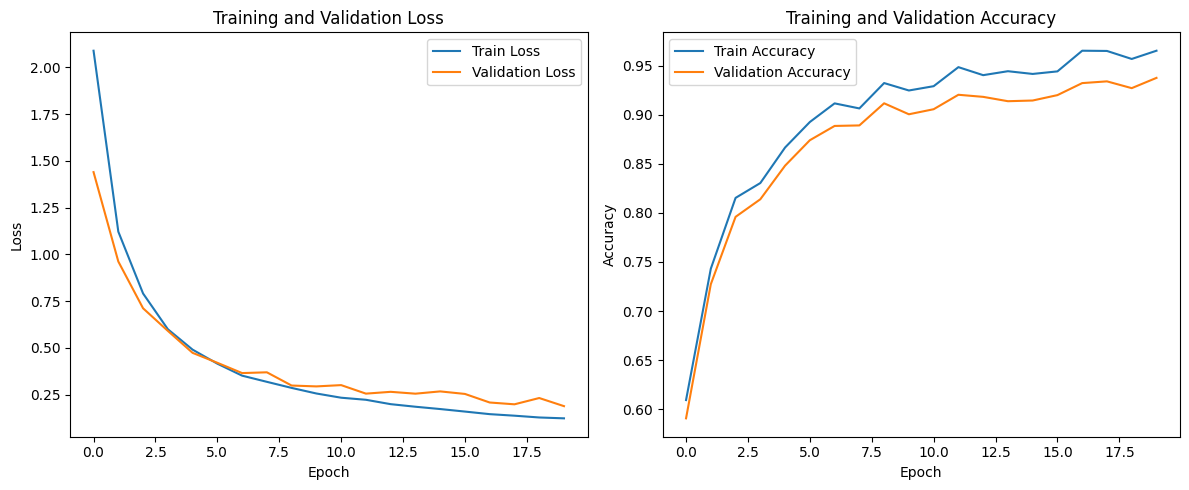

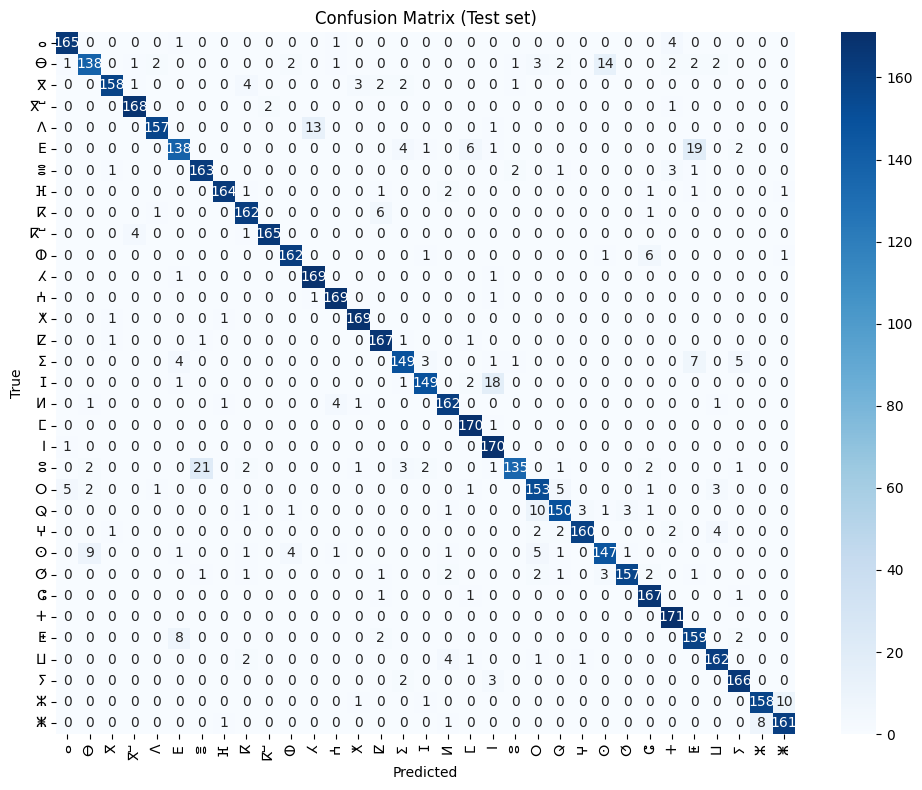

In [3]:
# Visualisations
# Courbes de perte et précision
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

# Matrice de confusion
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Test set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()
############
